# Import data

### Load DeepNTuples

In [1]:
import uproot
import numpy as np
import awkward1 as ak

import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
import torch
import torch.nn as nn

In [3]:
#open a DeepNTuple file. The one used here is not very big, you might want to use another one.
deepntuple = uproot.open('/afs/cern.ch/work/t/tmoxter/public/VertexingData/DNT_out_distSig0_l.root')['deepntuplizer/tree'].arrays()
d = {name.decode(): ak.from_awkward0(array) for name, array in deepntuple.items()}
d

{'n_sv': <Array [1, 1, 0, 0, 0, 1, ... 1, 1, 2, 1, 0, 2] type='21085 * uint32'>,
 'nsv': <Array [1, 1, 0, 0, 0, 1, ... 1, 1, 2, 1, 0, 2] type='21085 * float32'>,
 'sv_pt': <Array [[29.3], [23.4], ... [], [36.2, 11.8]] type='21085 * var * float32'>,
 'sv_eta': <Array [[-0.122], [1.6], ... [], [1.86, 1.98]] type='21085 * var * float32'>,
 'sv_phi': <Array [[-2.38], [0.346], ... [], [1.79, 1.75]] type='21085 * var * float32'>,
 'sv_etarel': <Array [[-0.475], [-0.49, ... [-0.465, -0.407]] type='21085 * var * float32'>,
 'sv_phirel': <Array [[-0.477], ... [-0.432, -0.471]] type='21085 * var * float32'>,
 'sv_deltaR': <Array [[-0.467], ... [-0.423, -0.403]] type='21085 * var * float32'>,
 'sv_mass': <Array [[2.23], [1.55], ... [], [1.12, 0.611]] type='21085 * var * float32'>,
 'sv_ntracks': <Array [[4], [3], [], [], ... [2], [], [4, 2]] type='21085 * var * float32'>,
 'sv_chi2': <Array [[6.02], [0.0189], ... [], [11.5, 4.87]] type='21085 * var * float32'>,
 'sv_ndf': <Array [[4.21], [2.91], 

We need to fill the input vector with data taken from the root file. Due to the way that the data is stored, we need to set some values to 0 if they do not exist. In this case, 0 is a unique default value for all variables where this is the case. (We want to set them to 0 after the preprocessing, but this allows for explicit identification of those values)

The chosen variables are all based on the file, the explainations of what they mean can be found in the in in the heavy flavour tagging paper (or more accurately in my thesis).

In [4]:
#Corrected input using default values of 0 if value doesn't exist
def fill_input_vector(d, i):
    input_vector = [ d['jet_pt'][i], d['jet_eta'][i],
                     d['TagVarCSV_jetNSecondaryVertices'][i],
                     d['TagVarCSV_trackSumJetEtRatio'][i], d['TagVarCSV_trackSumJetDeltaR'][i],
                     d['TagVarCSV_vertexCategory'][i], d['TagVarCSV_trackSip2dValAboveCharm'][i],
                     d['TagVarCSV_trackSip2dSigAboveCharm'][i], d['TagVarCSV_trackSip3dValAboveCharm'][i],
                     d['TagVarCSV_trackSip3dSigAboveCharm'][i], d['TagVarCSV_jetNSelectedTracks'][i],
                     d['TagVarCSV_jetNTracksEtaRel'][i],
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][0]if 0 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][0] if 0 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][0] if 0 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][0] if 0 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][0] if 0 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][0] if 0 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][0] if 0 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][1] if 1 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][1] if 1 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][1] if 1 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][1] if 1 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][1] if 1 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][1] if 1 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][1] if 1 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][2] if 2 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][2] if 2 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][2] if 2 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][2] if 2 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][2] if 2 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][2] if 2 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][2] if 2 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][3] if 3 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][3] if 3 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][3] if 3 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][3] if 3 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][3] if 3 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][3] if 3 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][3] if 3 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][4] if 4 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][4] if 4 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][4] if 4 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][4] if 4 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][4] if 4 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][4] if 4 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][4] if 4 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSVTrk_trackJetDistVal'][i][5] if 5 < len(d['TagVarCSVTrk_trackJetDistVal'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRel'][i][5] if 5 < len(d['TagVarCSVTrk_trackPtRel'][i]) else 0,
                     d['TagVarCSVTrk_trackDeltaR'][i][5] if 5 < len(d['TagVarCSVTrk_trackDeltaR'][i]) else 0,
                     d['TagVarCSVTrk_trackPtRatio'][i][5] if 5 < len(d['TagVarCSVTrk_trackPtRatio'][i]) else 0,
                     d['TagVarCSVTrk_trackSip3dSig'][i][5] if 5 < len(d['TagVarCSVTrk_trackSip3dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackSip2dSig'][i][5] if 5 < len(d['TagVarCSVTrk_trackSip2dSig'][i]) else 0,
                     d['TagVarCSVTrk_trackDecayLenVal'][i][5] if 5 < len(d['TagVarCSVTrk_trackDecayLenVal'][i]) else 0,
                    
                     d['TagVarCSV_trackEtaRel'][i][0] if 0 < len(d['TagVarCSV_trackEtaRel'][i]) else 0,
                     d['TagVarCSV_trackEtaRel'][i][1] if 1 < len(d['TagVarCSV_trackEtaRel'][i]) else 0,
                     d['TagVarCSV_trackEtaRel'][i][2] if 2 < len(d['TagVarCSV_trackEtaRel'][i]) else 0,
                     d['TagVarCSV_trackEtaRel'][i][3] if 3 < len(d['TagVarCSV_trackEtaRel'][i]) else 0,

                     d['TagVarCSV_vertexMass'][i][0] if 0 < len(d['TagVarCSV_vertexMass'][i]) else 0,
                     d['TagVarCSV_vertexNTracks'][i][0] if 0 < len(d['TagVarCSV_vertexNTracks'][i]) else 0,
                     d['TagVarCSV_vertexEnergyRatio'][i][0] if 0 < len(d['TagVarCSV_vertexEnergyRatio'][i]) else 0,
                     d['TagVarCSV_vertexJetDeltaR'][i][0] if 0 < len(d['TagVarCSV_vertexJetDeltaR'][i]) else 0,
                     d['TagVarCSV_flightDistance2dVal'][i][0] if 0 < len(d['TagVarCSV_flightDistance2dVal'][i]) else 0,
                     d['TagVarCSV_flightDistance2dSig'][i][0] if 0 < len(d['TagVarCSV_flightDistance2dSig'][i]) else 0,
                     d['TagVarCSV_flightDistance3dVal'][i][0] if 0 < len(d['TagVarCSV_flightDistance3dVal'][i]) else 0,
                     d['TagVarCSV_flightDistance3dSig'][i][0] if 0 < len(d['TagVarCSV_flightDistance3dSig'][i]) else 0
                   ]
    input_vector = torch.Tensor(input_vector)
    return input_vector

In [5]:
#The names of the input variables as I used them in my bachelor thesis.
input_names = ['Jet $p_T$','Jet $\eta$','Jet N Secondary Vertices','Track Sum Jet $E_T$ Ratio','Track Sum Jet $\Delta R$','Vertex Category','Track SIP 2D Val Above Charm','Track SIP 2D Sig Above Charm','Track SIP 3D Val Above Charm','Track SIP 3D Sig Above Charm','Jet N Selected Tracks','Jet N Tracks $\eta_{rel}$','Track Jet Dist Val [0]','Track $p_{T,rel}$ [0]','Track $\Delta R$ [0]','Track $p_T$ Ratio [0]','Track SIP 3D Sig [0]','Track SIP 2D Sig [0]','Track Decay Len Val [0]','Track Jet Dist Val [1]','Track $p_{T,rel}$ [1]','Track $\Delta R$ [1]','Track $p_T$ Ratio [1]','Track SIP 3D Sig [1]','Track SIP 2D Sig [1]','Track Decay Len Val [1]','Track Jet Dist Val [2]','Track $p_{T,rel}$ [2]','Track $\Delta R$ [2]','Track $p_T$ Ratio [2]','Track SIP 3D Sig [2]','Track SIP 2D Sig [2]','Track Decay Len Val [2]','Track Jet Dist Val [3]','Track $p_{T,rel}$ [3]','Track $\Delta R$ [3]','Track $p_T$ Ratio [3]','Track SIP 3D Sig [3]','Track SIP 2D Sig [3]','Track Decay Len Val [3]','Track Jet Dist Val [4]','Track $p_{T,rel}$ [4]','Track $\Delta R$ [4]','Track $p_T$ Ratio [4]','Track SIP 3D Sig [4]','Track SIP 2D Sig [4]','Track Decay Len Val [4]', 'Track Jet Dist Val [5]',  'Track $p_{T,rel}$ [5]', 'Track $\Delta R$ [5]','Track $p_{T,rel}$ Ratio [5]', 'Track SIP 3D Sig [5]', 'Track SIP 2D Sig [5]','Track Decay Len Val [5]','Track $\eta_{rel}$ [0]','Track $\eta_{rel}$ [1]','Track $\eta_{rel}$ [2]','Track $\eta_{rel}$ [3]','Vertex Mass','Vertex N Tracks','Vertex Energy Ratio','Vertex Jet Delta R','Flight Distance 2D Val','Flight Distance 2D Sig','Flight Distance 3D Val','Flight Distance 3D Sig']

The flavours in the file are mapped to one of the four flavour categories that will be used later.

In [6]:
def fill_target_vector(d,i): #The truth output
    goal_vector = [d['isB'][i]+d['isLeptonicB'][i]+d['isLeptonicB_C'][i], #b
                  d['isBB'][i]+d['isGBB'][i], #bb
                  d['isC'][i]+d['isCC'][i]+d['isGCC'][i], #c
                  d['isUD'][i]+d['isS'][i]+d['isG'][i]+d['isUndefined'][i]] #udsg
    goal_vector = torch.Tensor(goal_vector)
    return goal_vector

def fill_target_class(d,i): #
    target_class = 0*(d['isB'][i]+d['isLeptonicB'][i]+d['isLeptonicB_C'][i])+1*(d['isBB'][i])+2*(d['isC'][i]+d['isCC'][i])+3*(d['isUD'][i]+d['isS'][i]+d['isG'][i]+d['isGBB'][i]+d['isGCC'][i]+d['isUndefined'][i])
    return target_class

Bring the dataset in a from that can be used by the training algorithm.

In [7]:
n_jets = len(d['jet_pt'])
print(n_jets)

#This unfortunately takes long and is not very efficient
#dataset contains all inputs in its first component, and the true class in its second component
dataset = [[fill_input_vector(d,i),fill_target_class(d,i)] for i in range(n_jets)]

#DeepCSV_dataset contains the outputs of DeepCSV on the dataset
DeepCSV_dataset = torch.transpose(torch.Tensor([d['pfDeepCSVJetTags_probb'],d['pfDeepCSVJetTags_probbb'],d['pfDeepCSVJetTags_probc'],d['pfDeepCSVJetTags_probudsg']]),0,1).tolist()

21085


### Remove and inspect false jets

In [8]:
#some jets do not contain any meaningful data and are thus discarded. Example:
print(dataset[167][0])

tensor([  20.3051,    2.1308,    0.0000, -999.0000, -999.0000, -999.0000,
        -999.0000, -999.0000, -999.0000, -999.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000])


In [9]:
#remove those jets
i = 0
false_jets = []
while i < len(dataset):
    if dataset[i][0][3] == -999:
        dataset.pop(i)
        DeepCSV_dataset.pop(i)
        false_jets.append(i)
    else:
        i += 1
        
print(len(false_jets),'jets are false jets and were removed from the sample')

182 jets are false jets and were removed from the sample


### Preprocess Data for training

In [10]:
#Split the dataset into a train, test and validation set
from sklearn.model_selection import train_test_split

trainingset,testset,DeepCSV_trainingset,DeepCSV_testset = train_test_split(dataset,DeepCSV_dataset,test_size=0.2)
trainset, valset = train_test_split(trainingset,test_size=0.1)
DeepCSV_testset = np.array(DeepCSV_testset)
print(f"Training data: {len(trainset)}   Validation data: {len(valset)}   Test data: {len(testset)}")

Training data: 15049   Validation data: 1673   Test data: 4181


In [11]:
#This is unnecessarily complicated in its current form, there is probably an easier way to handle the data here
test_inputs = torch.tensor([np.array(testset[i][0]) for i in range(len(testset))])
test_targets = torch.tensor([testset[i][1] for i in range(len(testset))])
val_inputs = torch.tensor([np.array(valset[i][0]) for i in range(len(valset))])
val_targets = torch.tensor([valset[i][1] for i in range(len(valset))])
train_inputs = torch.tensor([np.array(trainset[i][0]) for i in range(len(trainset))])
train_targets = torch.tensor([trainset[i][1] for i in range(len(trainset))])

In [12]:
#The flavour distribution in the test set
n_b,n_bb,n_c,n_udsg = sum(test_targets==0),sum(test_targets==1),sum(test_targets==2),sum(test_targets==3)
print(f"Number of jets in test sample:\tb-jets: {n_b}\tbb-jets: {n_bb}\tc-jets: {n_c}\tudsg-jets: {n_udsg}")

#The flavour distribution in the whole dataset
n_b,n_bb,n_c,n_udsg = sum(test_targets==0)+sum(val_targets==0)+sum(train_targets==0), sum(test_targets==1)+sum(val_targets==1)+sum(train_targets==1), sum(test_targets==2)+sum(val_targets==2)+sum(train_targets==2), sum(test_targets==3)+sum(val_targets==3)+sum(train_targets==3)
n_ges = len(trainset)+len(valset)+len(testset)
print(f"Number of jets in all samples:\tb-jets: {n_b}\tbb-jets: {n_bb}\tc-jets: {n_c}\tudsg-jets: {n_udsg}")
print(f"Percentage of jets in all samples:\tb-jets: {n_b.item()/n_ges}\tbb-jets: {n_bb.item()/n_ges}\tc-jets: {n_c.item()/n_ges}\tudsg-jets: {n_udsg.item()/n_ges}")

Number of jets in test sample:	b-jets: 1401	bb-jets: 25	c-jets: 545	udsg-jets: 2210
Number of jets in all samples:	b-jets: 6893	bb-jets: 111	c-jets: 2740	udsg-jets: 11159
Percentage of jets in all samples:	b-jets: 0.3297612782854136	bb-jets: 0.005310242548916423	c-jets: 0.1310816629191982	udsg-jets: 0.5338468162464718


### Normalize inputs

All inputs are normalized. This accellerates the training process and is done for most ML applications (including DeepCSV).

For the first 12 variables, the whole set is normalized. The remaining variables are normalized seperately while ignoring the default values from before, to make sure that they do not influence normalization.

In [13]:
from sklearn.preprocessing import StandardScaler
norm_train_inputs,norm_val_inputs,norm_test_inputs = train_inputs.clone().detach(),val_inputs.clone().detach(),test_inputs.clone().detach()
scalers = []

for i in range(12): #normalize the inputs for the first 12 variables
    scaler = StandardScaler().fit(train_inputs[:,i].reshape(-1,1))
    norm_train_inputs[:,i] = torch.Tensor(scaler.transform(train_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i] = torch.Tensor(scaler.transform(val_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i] = torch.Tensor(scaler.transform(test_inputs[:,i].reshape(-1,1)).reshape(1,-1))
    scalers.append(scaler)
    
for i in range(12,66): #normalize the inputs for the remaining vairables, but ignore the non existant values, represented by a 0
    scaler = StandardScaler().fit(train_inputs[:,i][train_inputs[:,i]!=0].reshape(-1,1))
    norm_train_inputs[:,i][train_inputs[:,i]!=0] = torch.Tensor(scaler.transform(train_inputs[:,i][train_inputs[:,i]!=0].reshape(-1,1)).reshape(1,-1))
    norm_val_inputs[:,i][val_inputs[:,i]!=0] = torch.Tensor(scaler.transform(val_inputs[:,i][val_inputs[:,i]!=0].reshape(-1,1)).reshape(1,-1))
    norm_test_inputs[:,i][test_inputs[:,i]!=0] = torch.Tensor(scaler.transform(test_inputs[:,i][test_inputs[:,i]!=0].reshape(-1,1)).reshape(1,-1))
    scalers.append(scaler)

norm_trainset = [[norm_train_inputs[i],train_targets[i]] for i in range(len(trainset))]

In [14]:
#use normalized values in following code
raw_train_inputs = train_inputs.clone().detach()
raw_val_inputs = val_inputs.clone().detach()
raw_test_inputs = test_inputs.clone().detach()
print(len(torch.cat((raw_train_inputs,raw_val_inputs,raw_test_inputs))))

train_inputs = norm_train_inputs.clone().detach()
val_inputs = norm_val_inputs.clone().detach()
test_inputs = norm_test_inputs.clone().detach()
trainset = norm_trainset.copy()

20903


In [15]:
#This is just some plot styling
plt.style.use(hep.cms.style.ROOT)
C = ['firebrick', 'darkgreen', 'darkblue', 'grey', 'cyan','magenta']
path = 'Figures/'

# Build and train model

It is time to build a deep learning model. The architecture used here is identical to the one of DeepCSV.

In [16]:
#torch.nn.Sequential is a handy function that allows you to easily build basic neural networks and handles all the connectiong of layers for you
model = nn.Sequential(nn.Linear(66, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=66, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)


In [17]:
#The hyperparameters here are not thoroughly optimized. Choosing different ones might improve performance
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [19]:
#The training algorithm
import time
tic = time.time()
loss_history, val_loss_history = [], []
stale_epochs, min_loss = 0, 10
max_stale_epochs = 100 #I implemented some early stopping. The algorithm stops as soon as the loss has not gone down for max_stale_epochs
epochs = 100
#It might be useful to weigh the flavour categories, when working with other datasets. Here it was not necessary
for e in range(epochs):
    running_loss = 0
    for i,j in trainloader:
        optimizer.zero_grad()
        output = model(i)
        loss = criterion(output, j)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        with torch.no_grad():
            val_output = model(val_inputs)
            val_loss = criterion(val_output, val_targets)
            val_loss_history.append(val_loss)
            
            if stale_epochs > max_stale_epochs:
                print(f'training stopped by reaching {max_stale_epochs} stale epochs.                                                              ')
                break
            if val_loss.item() < min_loss:
                min_loss = val_loss.item()
                stale_epochs = 0
            else:
                stale_epochs += 1
            
            print(f"{(e)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/len(trainloader)}\tValidation loss: {val_loss}",end='\r')
        if (e)%np.floor(epochs/10)==0:
            print(f"{(e)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/len(trainloader)}\tValidation loss: {val_loss}")
        loss_history.append(running_loss/len(trainloader))
toc = time.time()
print(f"{(e+1)/epochs*100}% done. Epoch: {e}\tTraining loss: {running_loss/len(trainloader)}\tValidation loss: {val_loss}\nTraining complete. Time elapsed: {np.floor((toc-tic)/60)} min {np.ceil((toc-tic)%60)} s")

0.0% done. Epoch: 0	Training loss: 1.3848558462272256	Validation loss: 1.3816615343093872
10.0% done. Epoch: 10	Training loss: 1.0201899934623202	Validation loss: 1.009469151496887296139144897
20.0% done. Epoch: 20	Training loss: 0.9894743867344775	Validation loss: 0.982586860656738344232106208801
30.0% done. Epoch: 30	Training loss: 0.982946062492112	Validation loss: 0.9774153828620911804506301879883
40.0% done. Epoch: 40	Training loss: 0.9786500956042338	Validation loss: 0.9695909023284912
50.0% done. Epoch: 50	Training loss: 0.9778257413940915	Validation loss: 0.9759814143180847
60.0% done. Epoch: 60	Training loss: 0.9766022009869754	Validation loss: 0.97251170873641970181822776794
70.0% done. Epoch: 70	Training loss: 0.9736834302292032	Validation loss: 0.9731556177139282
80.0% done. Epoch: 80	Training loss: 0.9725901489540681	Validation loss: 0.9735127687454224
90.0% done. Epoch: 90	Training loss: 0.9724866755433001	Validation loss: 0.9689703583717346
100.0% done. Epoch: 99	Trainin

### Plot training history

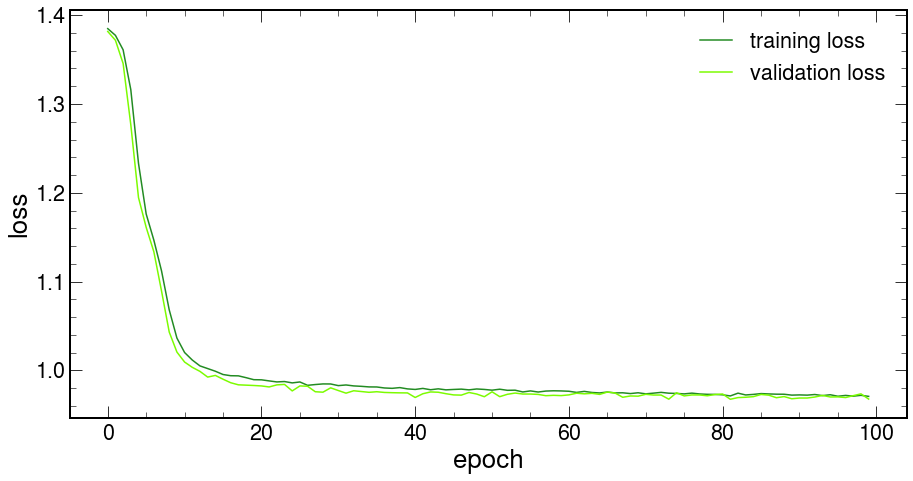

In [20]:
#Plot loss and validation loss over epochs
plt.figure(1,figsize=[15,7.5])
plt.plot(loss_history,color='forestgreen')
plt.plot(val_loss_history,color='lawngreen')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss','validation loss'])

You can save or load the model to skip training when executing the notebook multiple times.

In [21]:
torch.save(model, 'models/classifier.pt')

In [18]:
model = torch.load('models/classifier.pt')

# Check outputs

In [19]:
#evaluate network on inputs
predictions = model(test_inputs).detach().numpy()
print(predictions)

[[9.1775846e-08 1.4249651e-14 9.6962757e-11 9.9999988e-01]
 [1.0524017e-04 2.4524776e-09 5.8111931e-07 9.9989414e-01]
 [1.4586622e-07 5.3881833e-14 3.8245057e-10 9.9999988e-01]
 ...
 [4.7153990e-06 1.5577793e-11 1.8313575e-08 9.9999523e-01]
 [1.7147297e-05 1.1418101e-10 7.3823912e-08 9.9998283e-01]
 [6.4271539e-06 2.7652860e-12 4.8538742e-09 9.9999356e-01]]


In [20]:
import coffea.hist as hist

classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

jetFlavour = test_targets+1
classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])

Text(0.5, 0.98, 'Classifier and DeepCSV outputs')

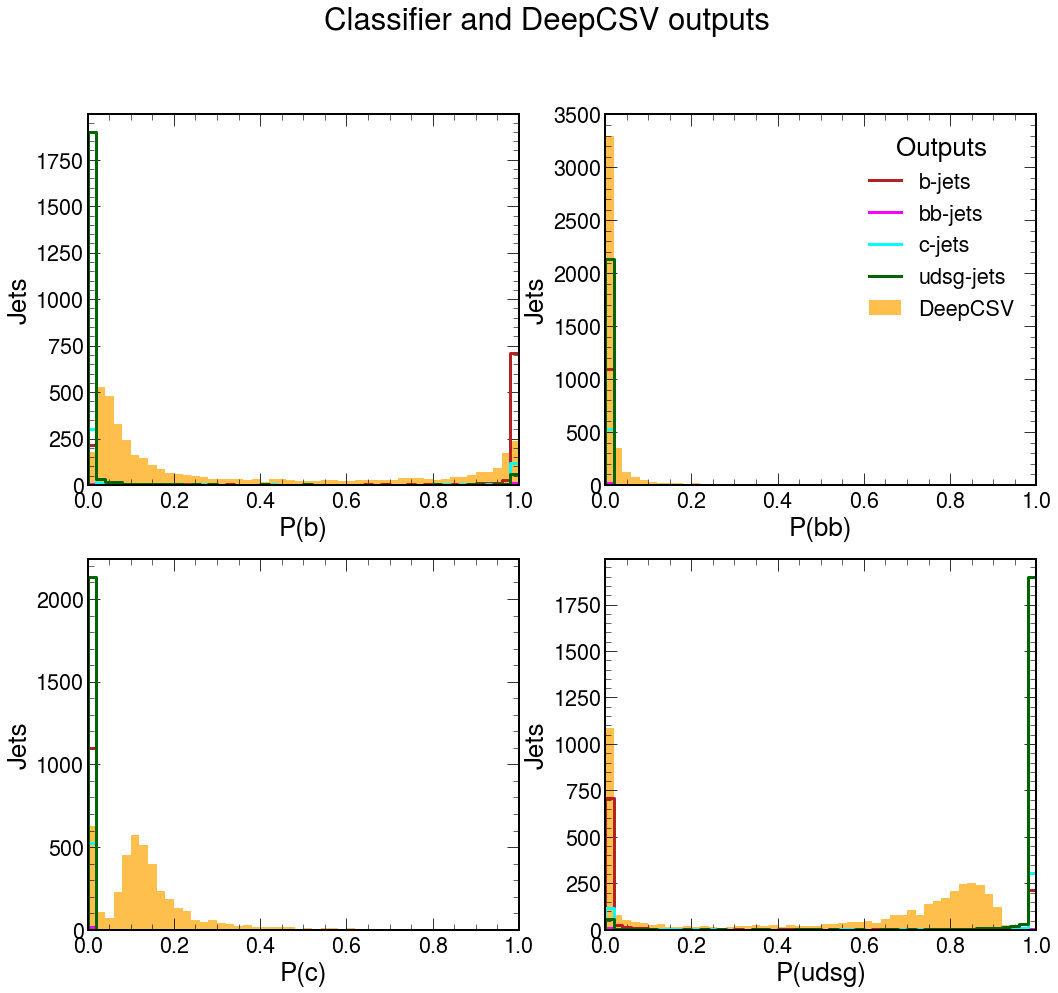

In [21]:
colorcode = ['firebrick','magenta','cyan','darkgreen']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0,3500)
fig.suptitle('Classifier and DeepCSV outputs')

A plot of the outputs of the network, where every plot corresponds to one of the output nodes. The outputs of the classifier are distinctly different from the outputs of DeepCSV, which is due to small differences in the training, eg. in the loss function and used train-set. The classification works anyway.

### Plot performance

auc for b-tagging: 0.9010942851714345
auc for bb-tagging: 0.4195765158806545
auc for c-tagging: 0.6201365549398978
auc for udsg-tagging: 0.8680863470549207


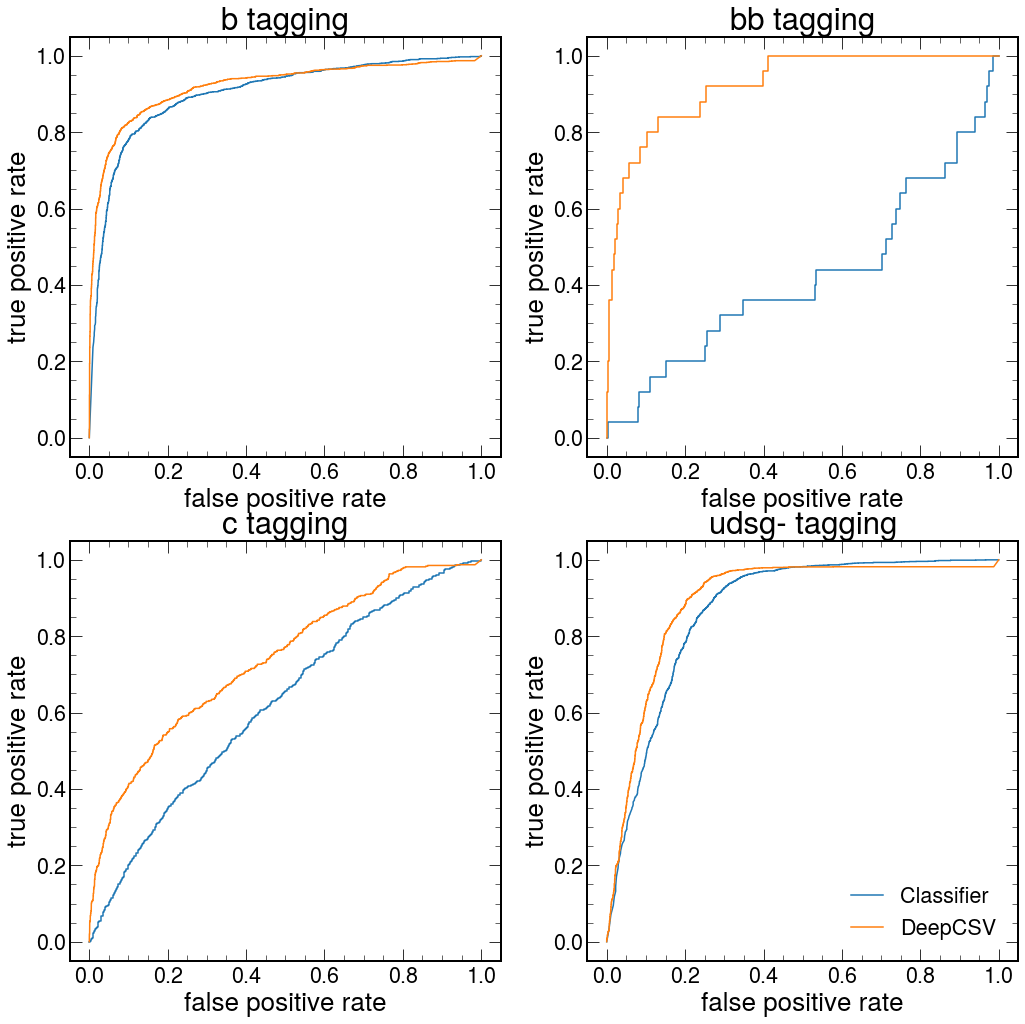

In [22]:
from sklearn import metrics

#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(testset))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(testset))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(testset))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(testset))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(testset))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(testset))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(testset))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(testset))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
#fig.suptitle('ROCs for every flavour')

Because, the ROCs depend on the composition of the sample, an independant version is needed. For that, only b and udsg jets are regarded. Here, I simply took P(b) as the discriminator, because it does not really change the outcome (P(bb) and P(c) are always 0 anyway)

In [23]:
BvsUDSG_inputs = torch.cat((test_inputs[jetFlavour==1],test_inputs[jetFlavour==4]))
BvsUDSG_targets = torch.cat((test_targets[jetFlavour==1],test_targets[jetFlavour==4]))
BvsUDSG_predictions = np.concatenate((predictions[jetFlavour==1],predictions[jetFlavour==4]))
BvsUDSG_DeepCSV = np.concatenate((DeepCSV_testset[jetFlavour==1],DeepCSV_testset[jetFlavour==4]))

auc for B vs UDSG: 0.9284680302692646


(0.4, 0.9)

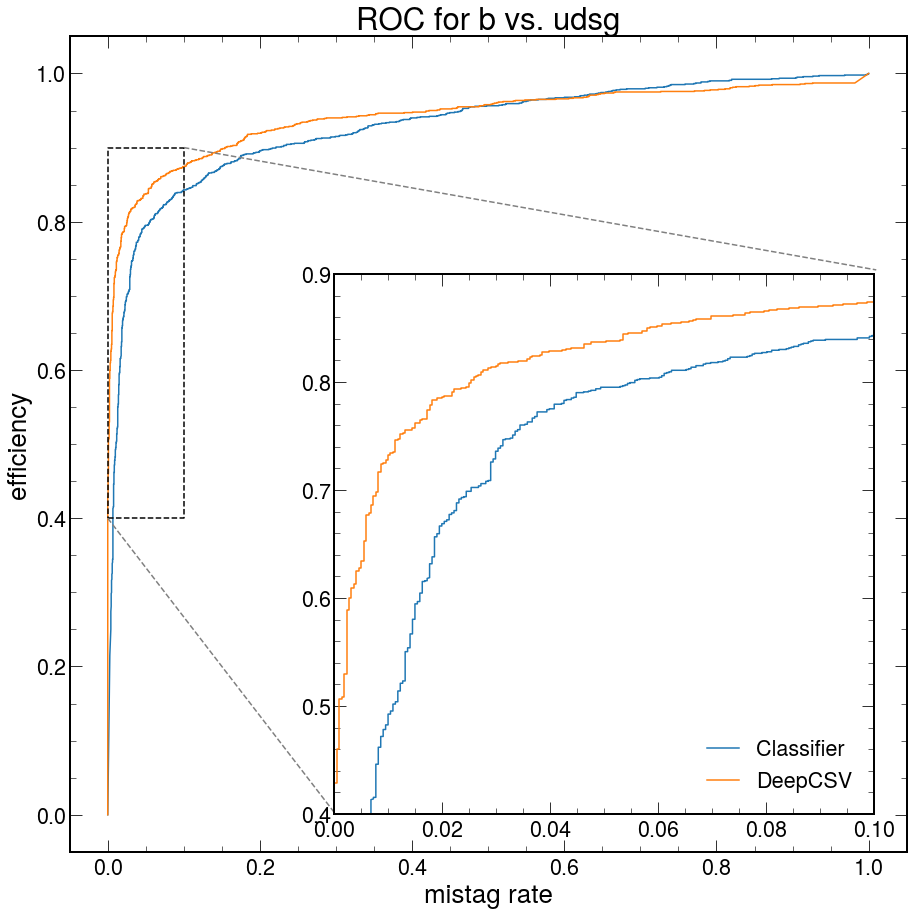

In [24]:
# plot ROC BvsUDSG

fig = plt.figure(figsize=[15,15],num=40)
fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_predictions[:,0])
plt.plot(fpr,tpr)
print(f"auc for B vs UDSG: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_DeepCSV[:,0])
plt.plot(fpr,tpr)

plt.xlabel('mistag rate')
plt.ylabel('efficiency')
plt.title('ROC for b vs. udsg')

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)
plt.plot([0,0.1,0.1,0,0],[0.4,0.4,0.9,0.9,0.4],'--',color='black')
plt.plot([0.1,1.01],[0.9,0.735],'--',color='grey')
plt.plot([0,0.3],[0.4,0.0],'--',color='grey')
ax = plt.axes([.37, .16, .5, .5])

fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_predictions[:,0])
plt.plot(fpr,tpr)
fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],BvsUDSG_DeepCSV[:,0])
plt.plot(fpr,tpr)
plt.legend(['Classifier','DeepCSV'],loc='lower right')
plt.xlim(0,0.1)
plt.ylim(0.4,0.9)

# Add Noise 

The first step is to investigate the networks reaction to noise. For that, gaussian distributed noise is added to the inputs and the network is evaluated on the modified set.

In [25]:
colormapping = ['blue','','','','purple','red','chocolate','grey']

def apply_noise(magn=[1],offset=[0]):
    
    fprl,tprl = [],[]
    for m in magn:
        noise = torch.Tensor(np.random.normal(offset,m,(len(BvsUDSG_inputs),66)))
        noise_predictions = model(BvsUDSG_inputs + noise).detach().numpy()
        
        fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],noise_predictions[:,0])
        fprl.append(fpr)
        tprl.append(tpr)
    
    plt.figure(5,[15,15])
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xlabel('mistag rate')
    plt.ylabel('efficiency')
    plt.title('ROCs with noise')
    
    plt.plot([0,0.1,0.1,0,0],[0.4,0.4,0.9,0.9,0.4],'--',color='black')
    plt.plot([0.1,1.01],[0.9,0.735],'--',color='grey')
    plt.plot([0,0.3],[0.4,0.0],'--',color='grey')
    
    for i in range(len(magn)):
        plt.plot(fprl[i],tprl[i],colormapping[i])
    
    ax = plt.axes([.37, .16, .5, .5])
    for i in range(len(magn)):
        ax.plot(fprl[i],tprl[i],colormapping[i])
        
    plt.xlim(0,0.1)
    plt.ylim(0.4,0.9)
    
    legend = [f'$\sigma={m}$' for m in magn]
    legend[0] = 'undisturbed'
    plt.legend(legend)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


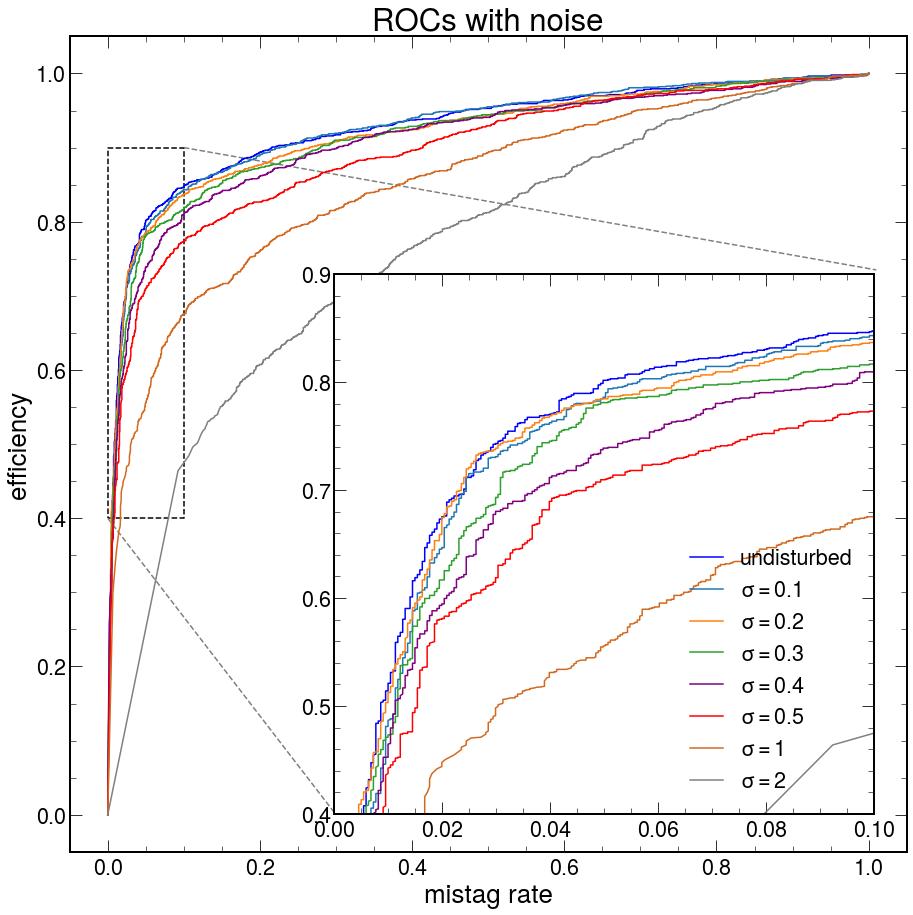

In [26]:
#The function allows to easily plot multiple sigma at once
apply_noise([0,0.1,0.2,0.3,0.4,0.5,1,2])

# FGSM attack

The main part of this notebook is the following: the FGSM attack (which I will not explain here) is applied to generate an adversarial sample. The code is loosely based on a notebook by Chase Shimmins from MLHEP2020.

In [27]:
#This function generates an adversarial sample
def fgsm_attack(epsilon=1e-1,sample=BvsUDSG_inputs,targets=BvsUDSG_targets,reduced=True):
    xadv = sample.clone().detach()
    
    # calculate the gradient of the model w.r.t. the *input* tensor:
    # first we tell torch that x should be included in grad computations
    xadv.requires_grad = True
    
    # then we just do the forward and backwards pass as usual:
    preds = model(xadv)
    loss = criterion(preds, targets).mean()
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        #now we obtain the gradient of the input. It has the same dimensions as the tensor xadv, and it "points" in the direction of increasing loss values.
        dx = torch.sign(xadv.grad.detach())
        
        #so, we take a step in that direction!
        xadv += epsilon*torch.sign(dx)
        
        #remove the impact on selected variables. This is nessecary to avoid problems that occur otherwise in the input shapes.
        if reduced:
            xadv[:,2] = sample[:,2]
            xadv[:,5] = sample[:,5]
            xadv[:,10] = sample[:,10]
            xadv[:,11] = sample[:,11]
            xadv[:,59] = sample[:,59]
            xadv[:,12:][sample[:,12:]==0] = 0
            for i in range(6,10):
                defaults = scalers[i].inverse_transform(sample[:,i]) == -1 #this number might change due to some weird rounding error
                if np.sum(defaults) != 0:
                    for i in range(6,10):
                        xadv[:,i][defaults] = sample[:,i][defaults]
                    break
        return xadv.detach()

In [28]:
#This function is just for the nice plots
def execute_fgsm(epsilon=[1e-1],reduced=True):
    
    fprl,tprl = [],[]
    for e in epsilon:
        adv_inputs = fgsm_attack(e,reduced=reduced)
        fgsm_predictions = model(adv_inputs).detach().numpy()
        
        fpr,tpr,thresholds = metrics.roc_curve([(1 if BvsUDSG_targets[i]==0 else 0) for i in range(len(BvsUDSG_targets))],fgsm_predictions[:,0])
        fprl.append(fpr)
        tprl.append(tpr)
    
    plt.figure(5,[15,15])
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.xlabel('mistag rate')
    plt.ylabel('efficiency')
    if reduced:
        plt.title('ROCs with reduced FGSM')
    else:
        plt.title('ROCs with full FGSM')
    
    plt.plot([0,0.1,0.1,0,0],[0.4,0.4,0.9,0.9,0.4],'--',color='black')
    plt.plot([0.1,1.01],[0.9,0.735],'--',color='grey')
    plt.plot([0,0.3],[0.4,0.0],'--',color='grey')

    for i in range(len(epsilon)):
        plt.plot(fprl[i],tprl[i],colormapping[i])
        
    ax = plt.axes([.37, .16, .5, .5])
    for i in range(len(epsilon)):
        ax.plot(fprl[i],tprl[i],colormapping[i])
        
    plt.xlim(0,0.1)
    plt.ylim(0.4,0.9)
    
    legend = [f'$\epsilon={e}$' for e in epsilon]
    legend[0] = 'undisturbed'
    plt.legend(legend)
    

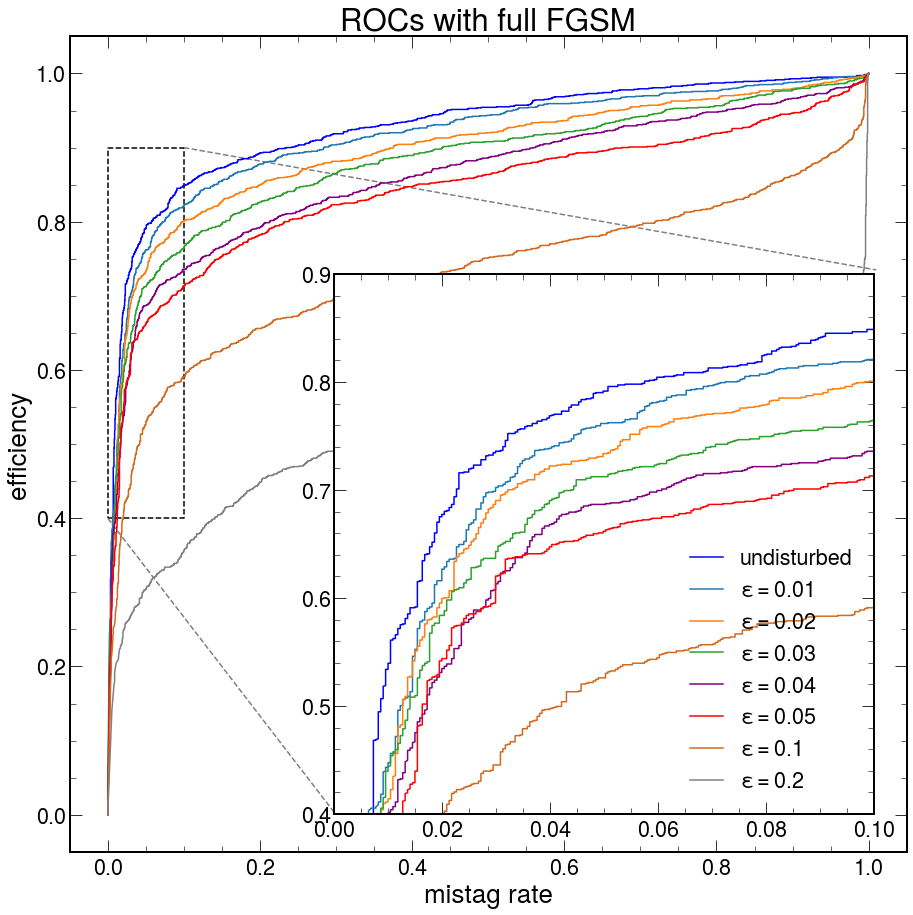

In [29]:
execute_fgsm([0,0.01,0.02,0.03,0.04,0.05,0.1,0.2],False)

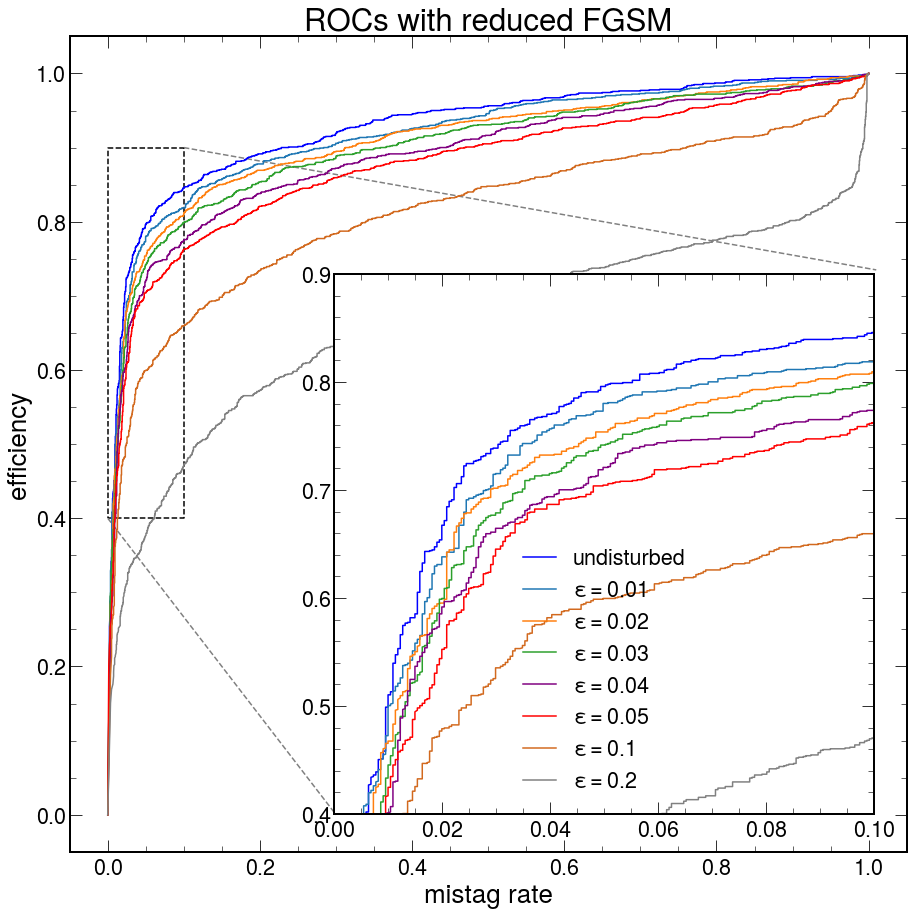

In [30]:
execute_fgsm([0,0.01,0.02,0.03,0.04,0.05,0.1,0.2],True)

### Compare FGSM inputs with undisturbed inputs

In [31]:
np.seterr(divide='ignore',invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [32]:
#percantage of default values
print(f'percentage of default values for first track varables:\t{len(test_inputs[:,12][test_inputs[:,12]==0])/len(test_inputs[:,12])*100}%')
print(f'percentage of default values for second track vaiables:\t{len(test_inputs[:,19][test_inputs[:,19]==0])/len(test_inputs[:,19])*100}%')
print(f'percentage of default values for third track vaiables:\t{len(test_inputs[:,26][test_inputs[:,26]==0])/len(test_inputs[:,26])*100}%')
print(f'percentage of default values for fourth track vaiables:\t{len(test_inputs[:,33][test_inputs[:,33]==0])/len(test_inputs[:,33])*100}%')
print(f'percentage of default values for fifth track vaiables:\t{len(test_inputs[:,40][test_inputs[:,40]==0])/len(test_inputs[:,40])*100}%')
print(f'percentage of default values for sixth track vaiables:\t{len(test_inputs[:,47][test_inputs[:,47]==0])/len(test_inputs[:,47])*100}%')
print(f'percentage of default values for first track relEta:\t{len(test_inputs[:,54][test_inputs[:,54]==0])/len(test_inputs[:,54])*100}%')
print(f'percentage of default values for second track relEta:\t{len(test_inputs[:,55][test_inputs[:,55]==0])/len(test_inputs[:,55])*100}%')
print(f'percentage of default values for third track relEta:\t{len(test_inputs[:,56][test_inputs[:,56]==0])/len(test_inputs[:,56])*100}%')
print(f'percentage of default values for fourth track relEta:\t{len(test_inputs[:,57][test_inputs[:,57]==0])/len(test_inputs[:,57])*100}%')
print(f'percentage of default values for first sv variables:\t{len(test_inputs[:,58][test_inputs[:,58]==0])/len(test_inputs[:,58])*100}%')
print(f'percentage of default -1 values for jet variables:\t{np.sum(scalers[8].inverse_transform(test_inputs[:,8])==-1)/len(test_inputs[:,7])*100}%')

percentage of default values for first track varables:	1.5546519971298733%
percentage of default values for second track vaiables:	8.70605118392729%
percentage of default values for third track vaiables:	23.176273618751495%
percentage of default values for fourth track vaiables:	42.932312843817265%
percentage of default values for fifth track vaiables:	62.353503946424304%
percentage of default values for sixth track vaiables:	77.58909351829706%
percentage of default values for first track relEta:	46.9265725902894%
percentage of default values for second track relEta:	46.9265725902894%
percentage of default values for third track relEta:	62.97536474527625%
percentage of default values for fourth track relEta:	75.0059794307582%
percentage of default values for first sv variables:	46.9265725902894%
percentage of default -1 values for jet variables:	17.818703659411625%


In [33]:
#This is a function to create comparison plots for each input variable

def compare_inputs(prop=0,epsilon=0.1,minimum=None,maximum=None,reduced=True):
    all_inputs = torch.cat((test_inputs,val_inputs,train_inputs))
    all_targets = torch.cat((test_targets,val_targets,train_targets))
    x = scalers[prop].inverse_transform(all_inputs[:,prop])
    xadv = scalers[prop].inverse_transform(fgsm_attack(epsilon,all_inputs,all_targets,reduced=reduced)[:,prop])
    
    if minimum is None:
        minimum = min(min(x),min(xadv))
    if maximum is None:
        maximum = max(max(x),max(xadv))
        
    compHist = hist.Hist("Jets",
                          hist.Cat("sample","sample name"),
                          hist.Bin("prop",input_names[prop],100,minimum,maximum))
    compHist.fill(sample="raw",prop=x)
    compHist.fill(sample=f"fgsm $\epsilon$={epsilon}",prop=xadv)
    
    bins = np.linspace(minimum+(maximum-minimum)/100/2,maximum-(maximum-minimum)/100/2,100)
    num = compHist[f"fgsm $\epsilon$={epsilon}"].sum('sample').values()[()]
    denom = compHist['raw'].sum('sample').values()[()]
    ratio = num / denom
    num_err = np.sqrt(num)
    denom_err = np.sqrt(denom)
    ratio_err = np.sqrt((num_err/denom)**2+(num/(denom**2)*denom_err)**2)
    
    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=[10,5],gridspec_kw={'height_ratios': [3, 1],'hspace': .3})
    hist.plot1d(compHist,overlay='sample',ax=ax1,line_opts={'c':['blue','red']})
    ax1.get_legend().remove()
    ax1.legend(['FGSM','raw'])
    ax2.errorbar(bins,ratio,yerr=ratio_err,fmt='.',color='black')
    ax2.plot([minimum,maximum],[1,1],color='black')
    ax2.set_ylim(0,2)
    ax2.set_xlim(minimum,maximum)
    ax2.set_ylabel('FGSM/raw')

Some of the probelmatic values when the full FGSM attack is applied:

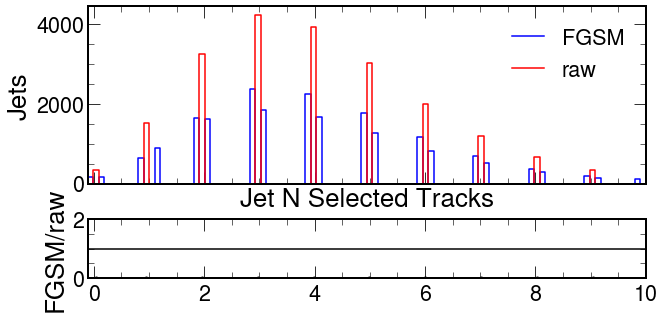

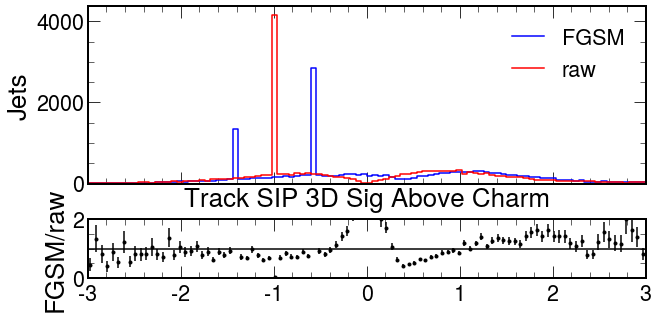

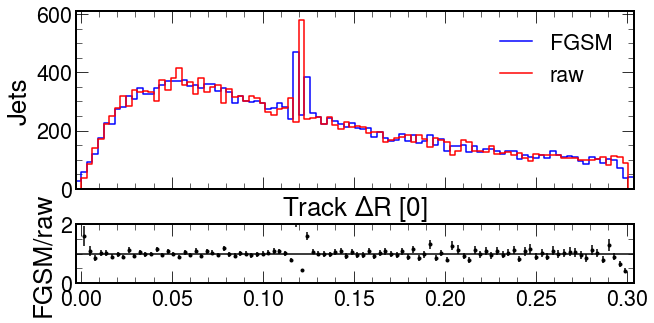

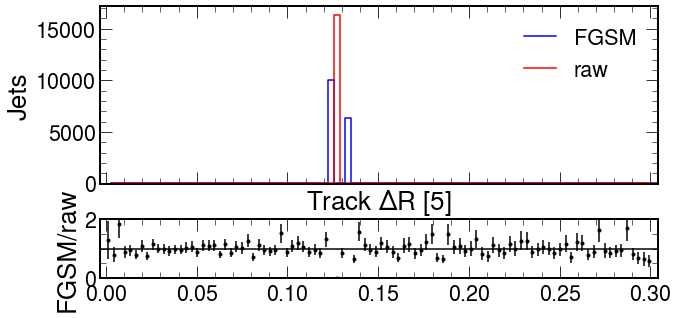

In [34]:
epsilon = 0.05
compare_inputs(10,epsilon,minimum=None,maximum=10,reduced=False)
compare_inputs(9,epsilon,minimum=-3,maximum=3,reduced=False)
compare_inputs(14,epsilon,minimum=None,maximum=None,reduced=False)
compare_inputs(49,epsilon,minimum=None,maximum=None,reduced=False)

All input shapes with the reduced FGSM:

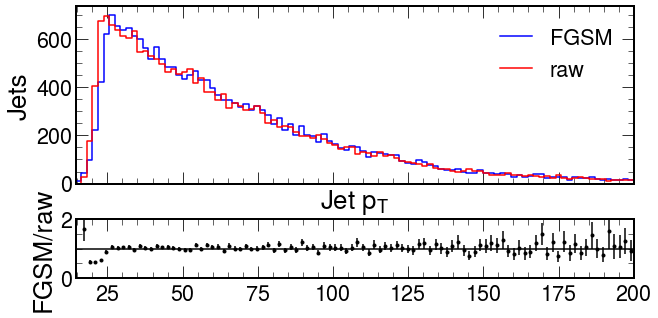

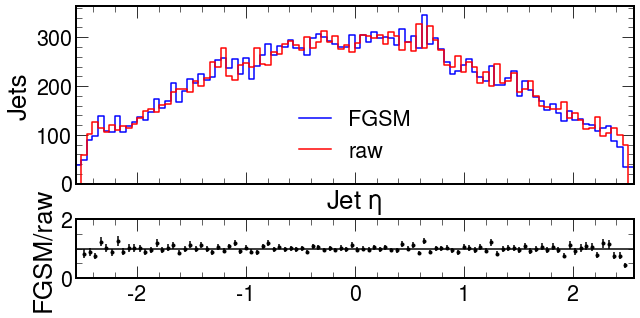

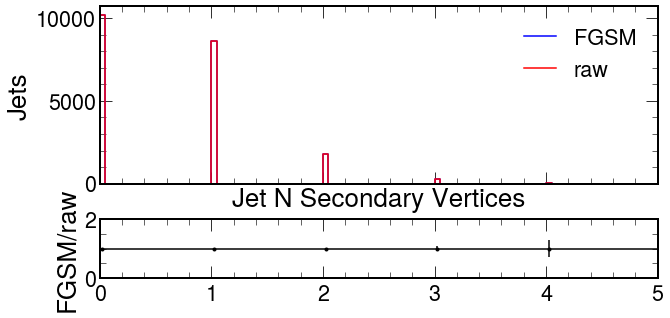

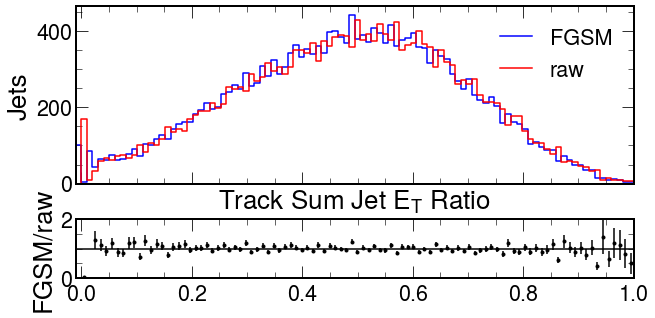

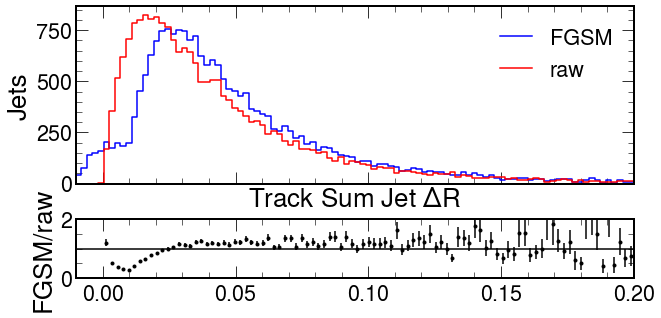

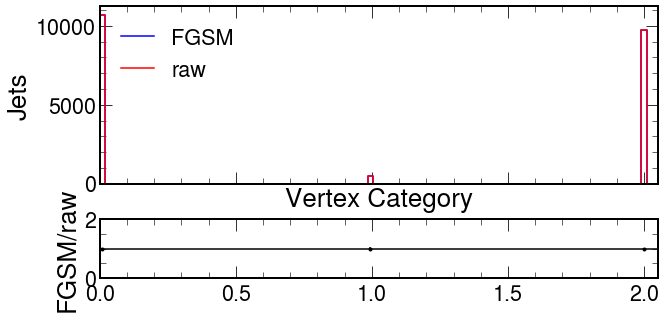

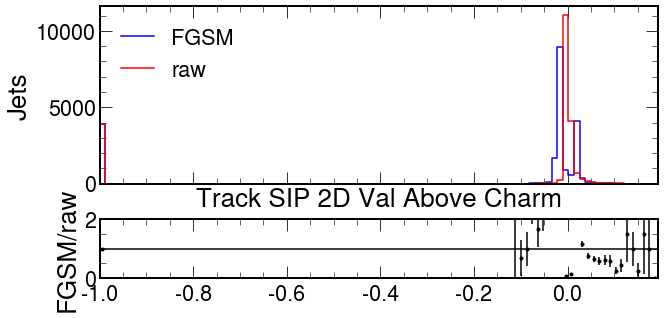

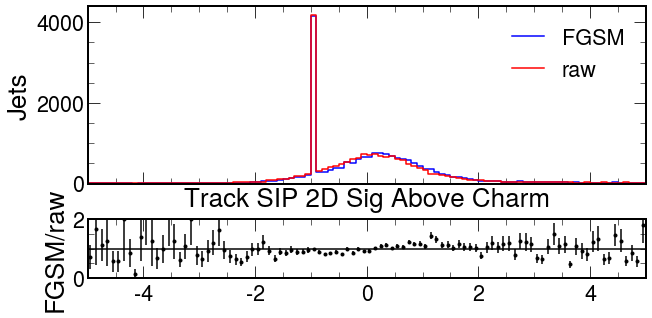

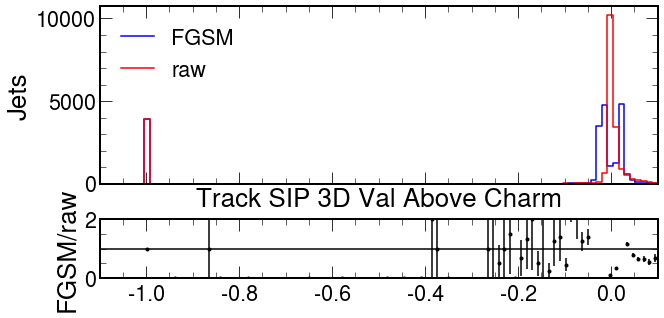

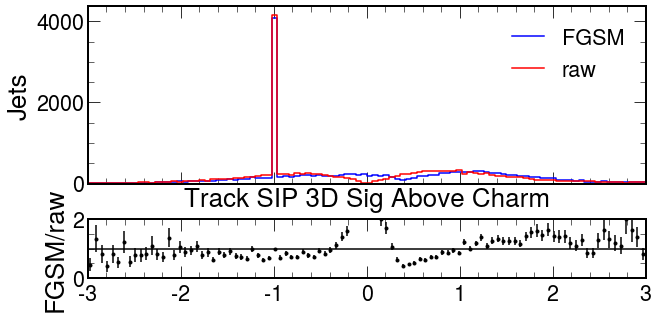

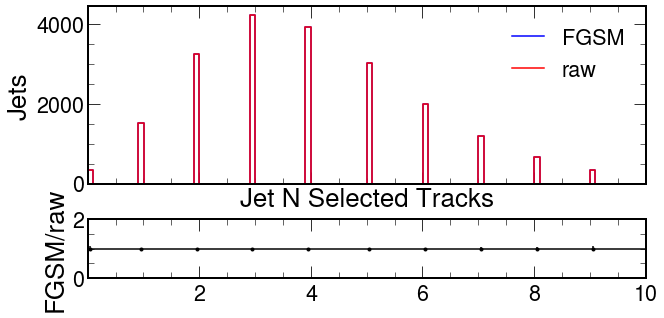

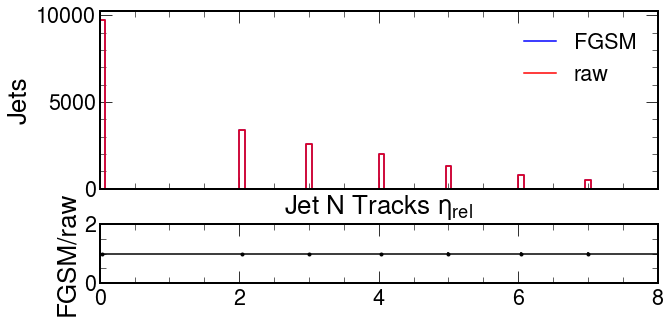

In [35]:
epsilon = 0.05
compare_inputs(0,epsilon,minimum=None,maximum=200)
compare_inputs(1,epsilon,minimum=None,maximum=None)
compare_inputs(2,epsilon,minimum=None,maximum=None)
compare_inputs(3,epsilon,minimum=None,maximum=1)
compare_inputs(4,epsilon,minimum=None,maximum=0.2)
compare_inputs(5,epsilon,minimum=None,maximum=2.05)
compare_inputs(6,epsilon,minimum=None,maximum=None)
compare_inputs(7,epsilon,minimum=-5,maximum=5)
compare_inputs(8,epsilon,minimum=-1.1,maximum=0.1)
compare_inputs(9,epsilon,minimum=-3,maximum=3)
compare_inputs(10,epsilon,minimum=None,maximum=10)
compare_inputs(11,epsilon,minimum=None,maximum=8)

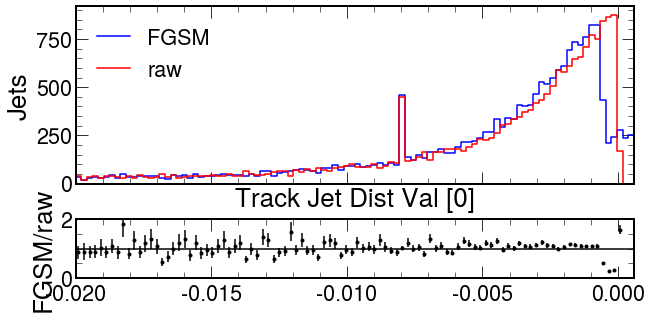

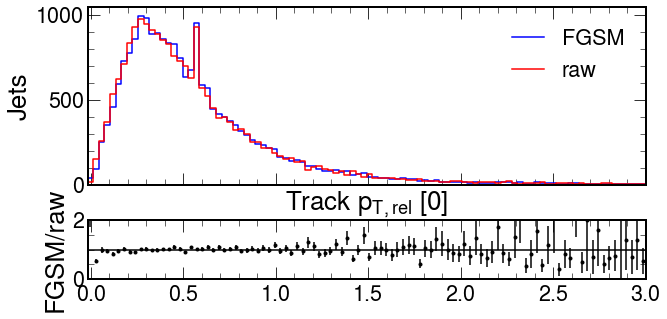

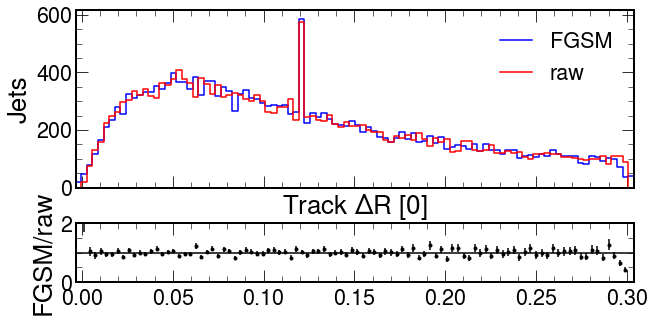

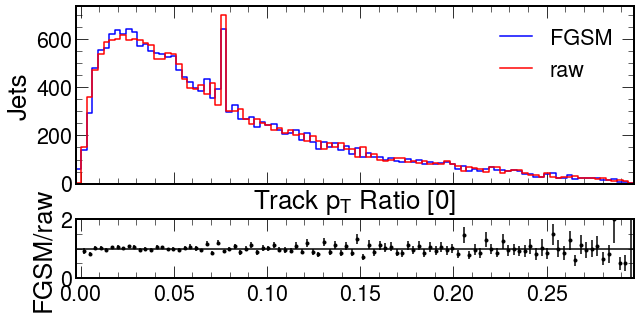

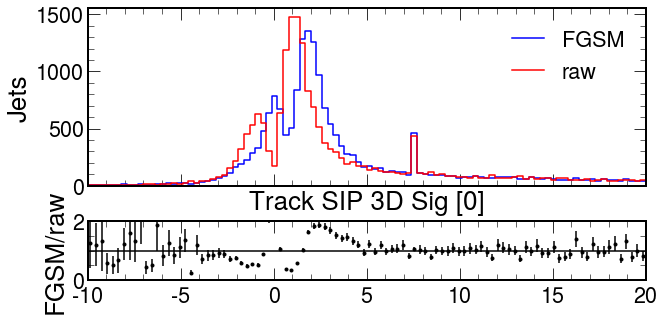

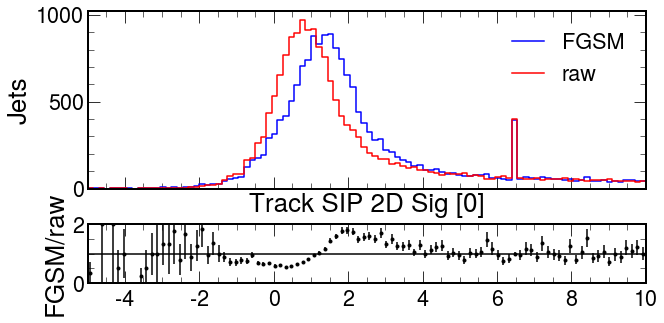

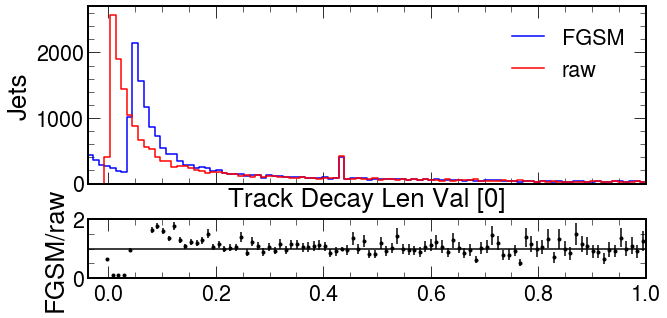

In [36]:
compare_inputs(12,epsilon,minimum=-0.02,maximum=None)
compare_inputs(13,epsilon,minimum=None,maximum=3)
compare_inputs(14,epsilon,minimum=None,maximum=None)
compare_inputs(15,epsilon,minimum=None,maximum=None)
compare_inputs(16,epsilon,minimum=-10,maximum=20)
compare_inputs(17,epsilon,minimum=-5,maximum=10)
compare_inputs(18,epsilon,minimum=None,maximum=1)

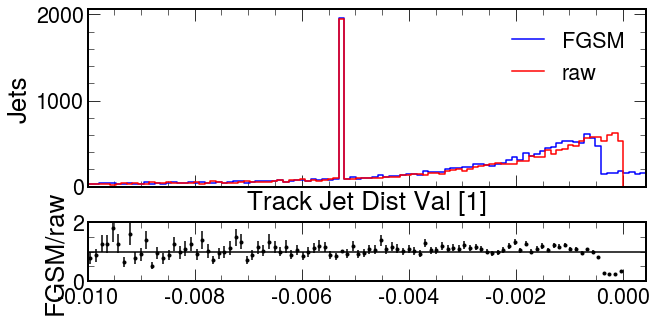

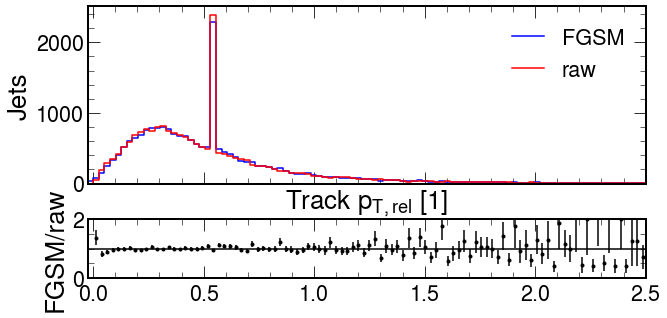

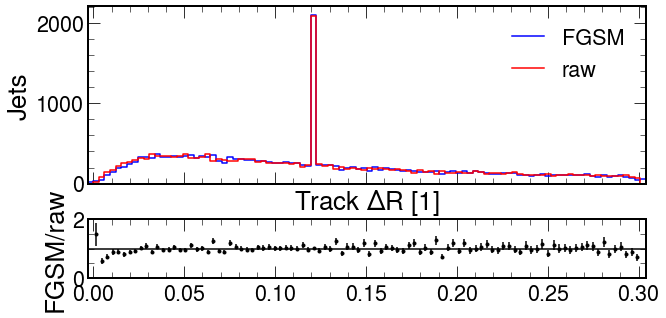

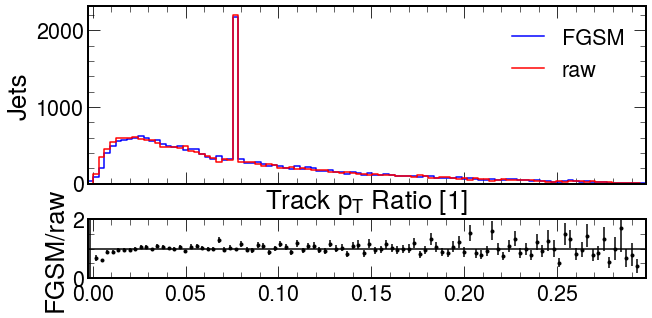

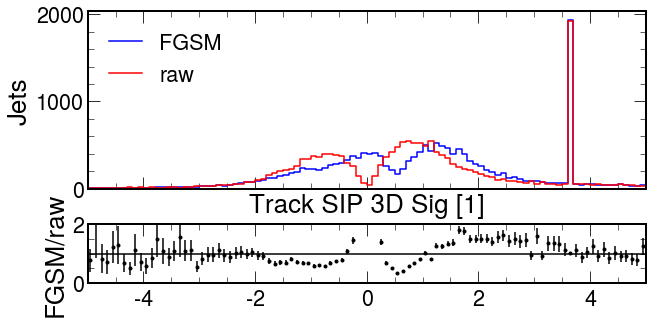

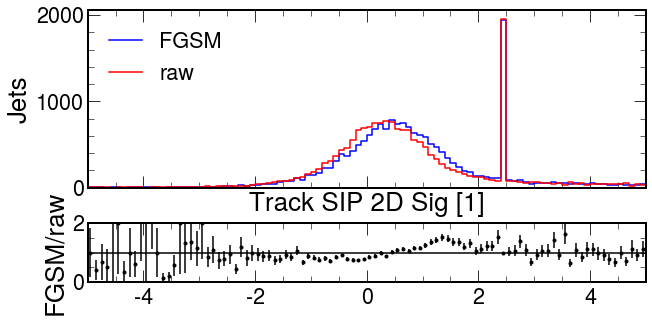

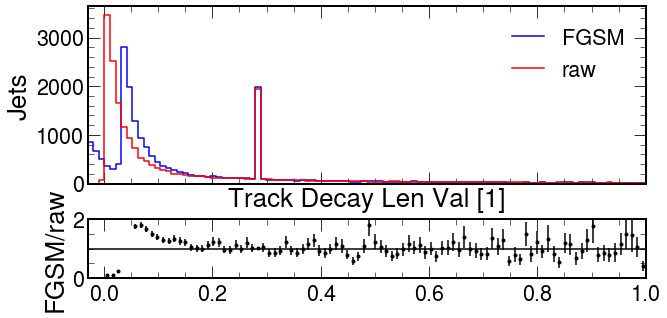

In [37]:
compare_inputs(19,epsilon,minimum=-0.01,maximum=None)
compare_inputs(20,epsilon,minimum=None,maximum=2.5)
compare_inputs(21,epsilon,minimum=None,maximum=None)
compare_inputs(22,epsilon,minimum=None,maximum=None)
compare_inputs(23,epsilon,minimum=-5,maximum=5)
compare_inputs(24,epsilon,minimum=-5,maximum=5)
compare_inputs(25,epsilon,minimum=None,maximum=1)

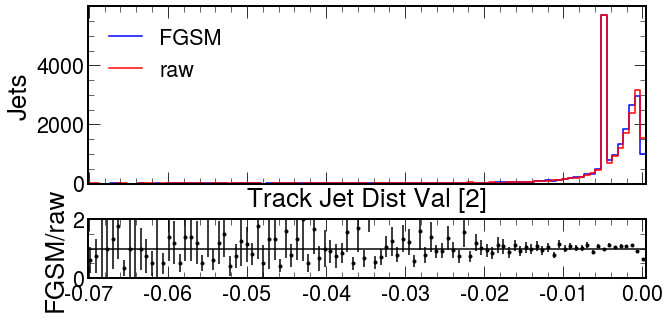

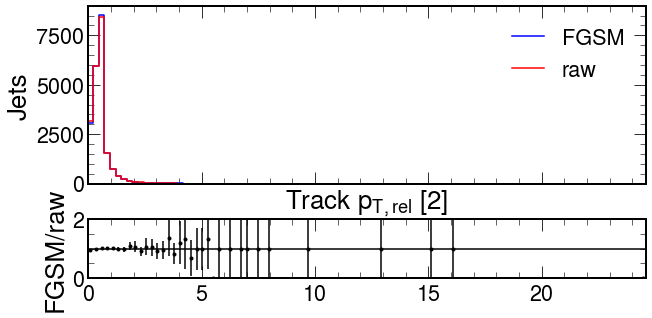

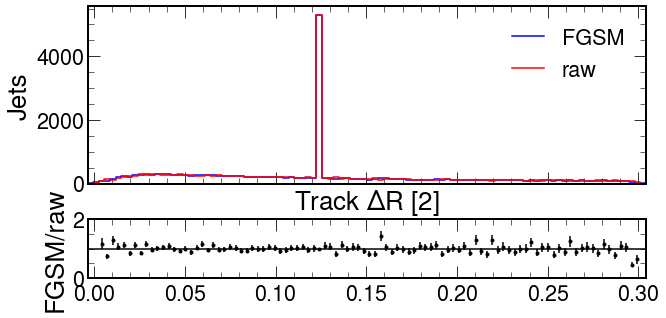

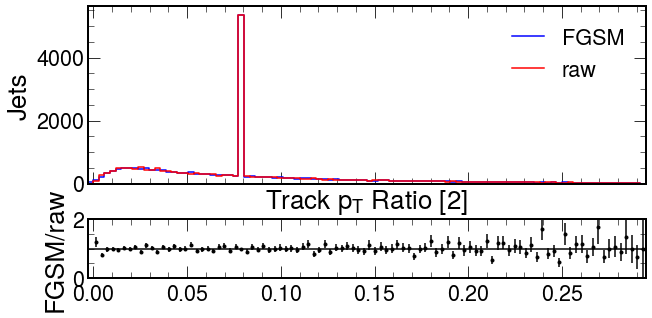

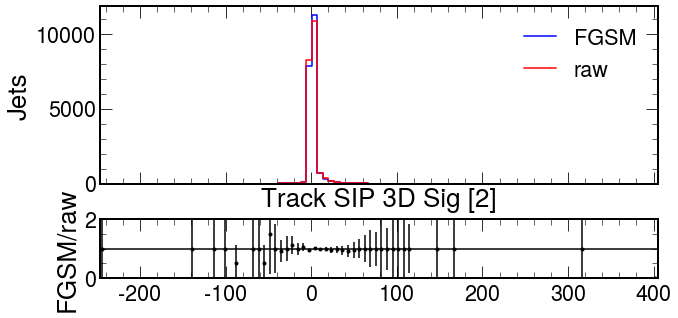

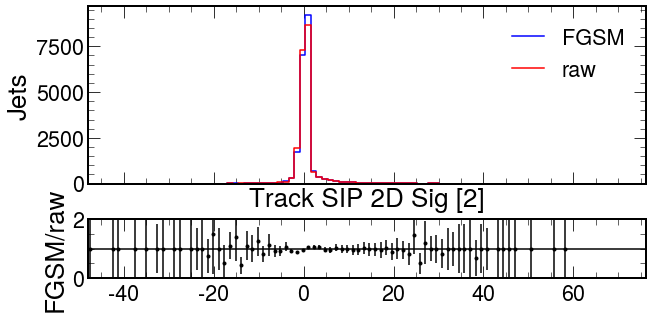

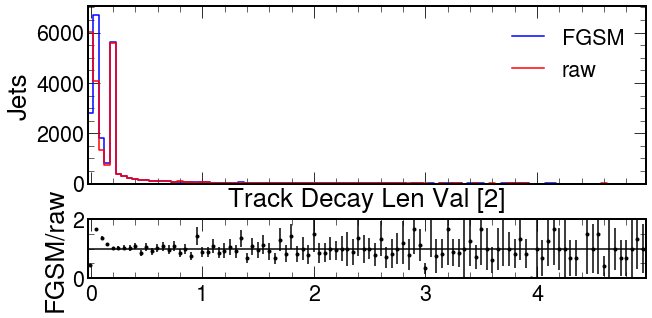

In [38]:
compare_inputs(26,epsilon,minimum=None,maximum=None)
compare_inputs(27,epsilon,minimum=None,maximum=None)
compare_inputs(28,epsilon,minimum=None,maximum=None)
compare_inputs(29,epsilon,minimum=None,maximum=None)
compare_inputs(30,epsilon,minimum=None,maximum=None)
compare_inputs(31,epsilon,minimum=None,maximum=None)
compare_inputs(32,epsilon,minimum=None,maximum=None)

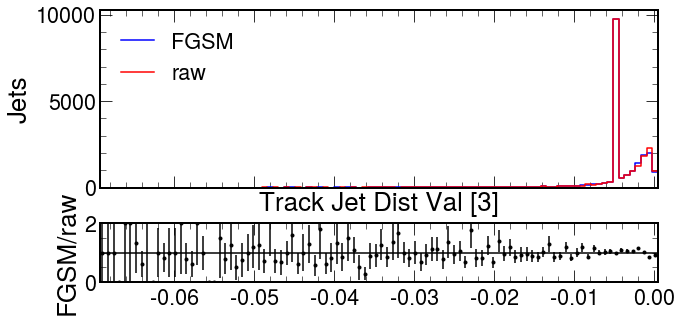

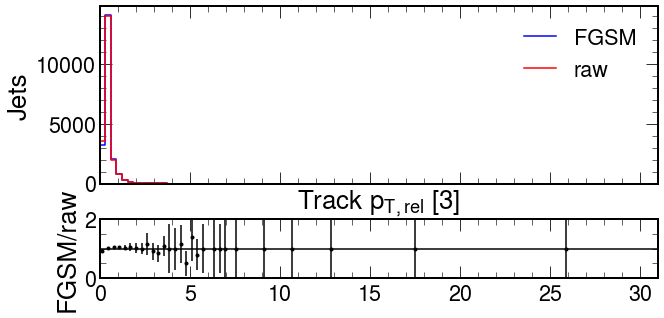

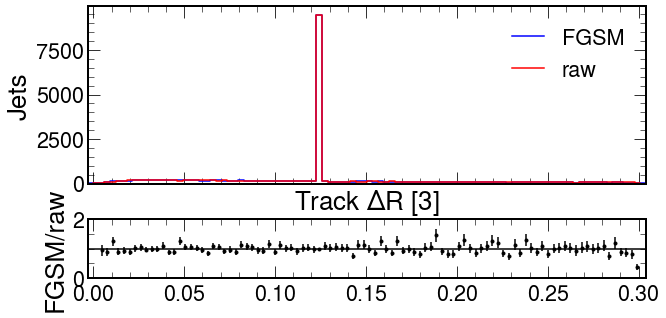

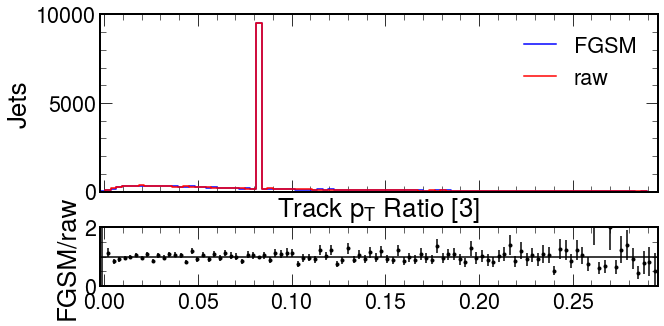

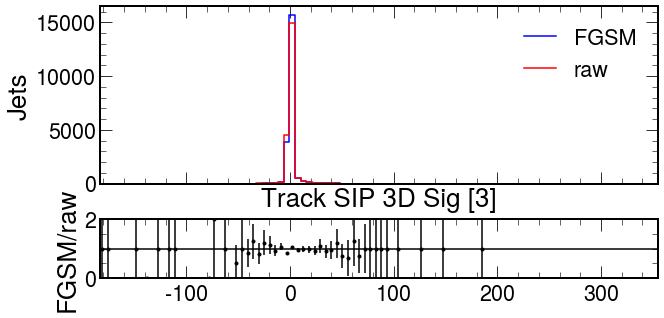

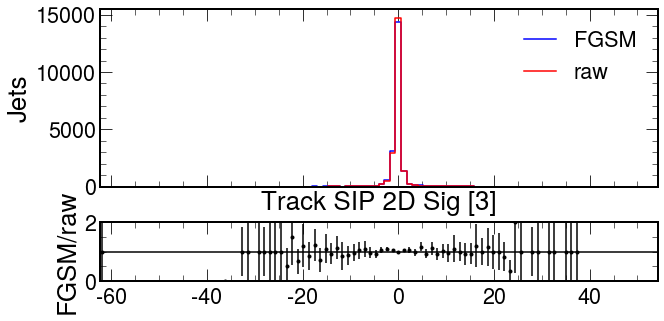

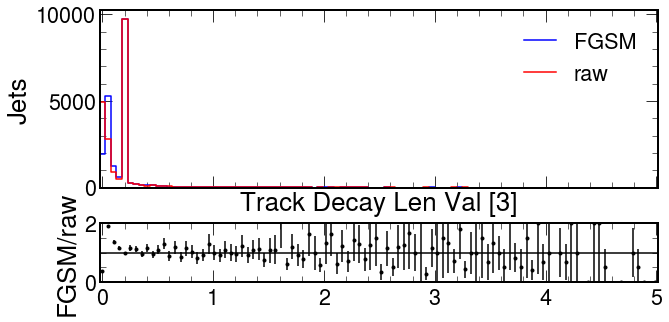

In [39]:
compare_inputs(33,epsilon,minimum=None,maximum=None)
compare_inputs(34,epsilon,minimum=None,maximum=None)
compare_inputs(35,epsilon,minimum=None,maximum=None)
compare_inputs(36,epsilon,minimum=None,maximum=None)
compare_inputs(37,epsilon,minimum=None,maximum=None)
compare_inputs(38,epsilon,minimum=None,maximum=None)
compare_inputs(39,epsilon,minimum=None,maximum=None)

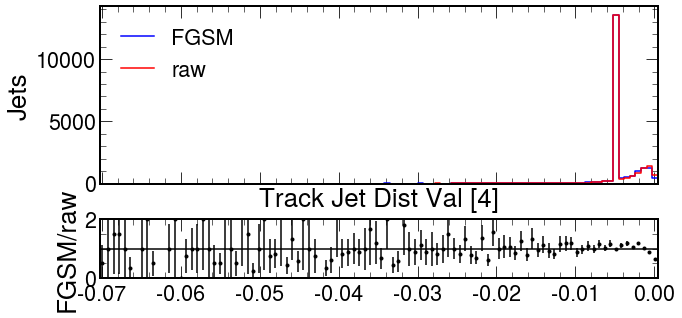

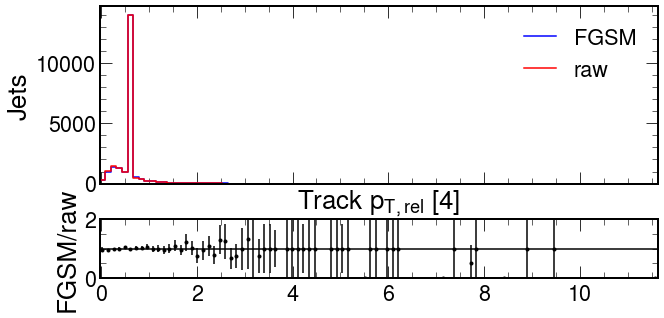

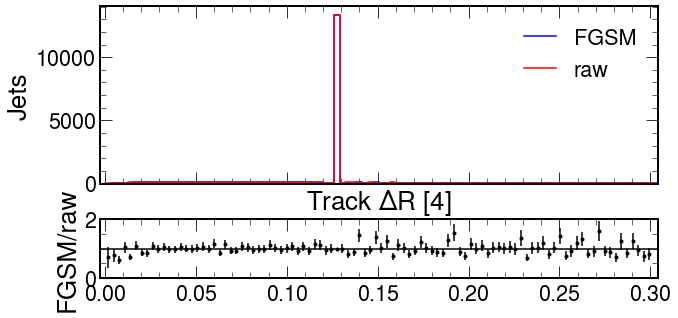

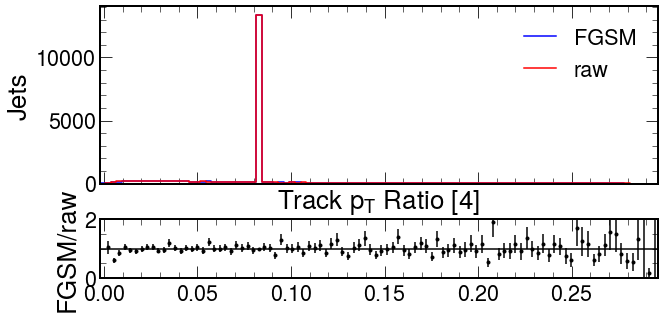

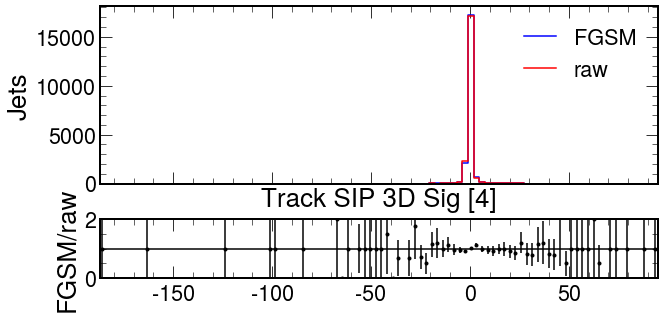

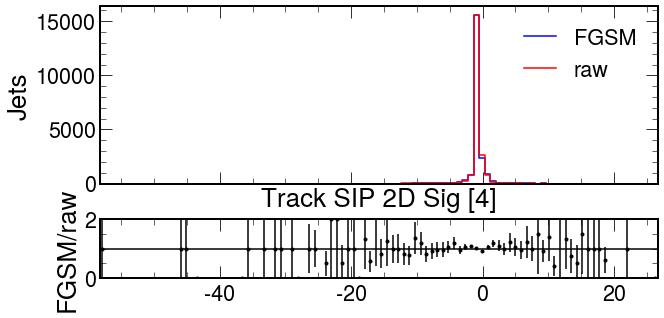

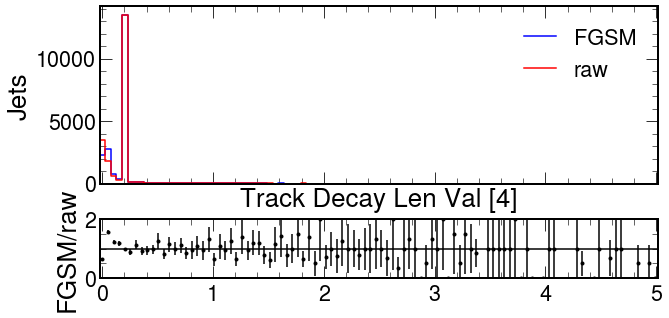

In [40]:
compare_inputs(40,epsilon,minimum=None,maximum=None)
compare_inputs(41,epsilon,minimum=None,maximum=None)
compare_inputs(42,epsilon,minimum=None,maximum=None)
compare_inputs(43,epsilon,minimum=None,maximum=None)
compare_inputs(44,epsilon,minimum=None,maximum=None)
compare_inputs(45,epsilon,minimum=None,maximum=None)
compare_inputs(46,epsilon,minimum=None,maximum=None)

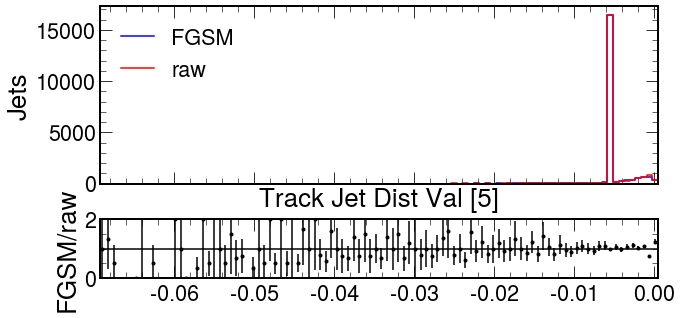

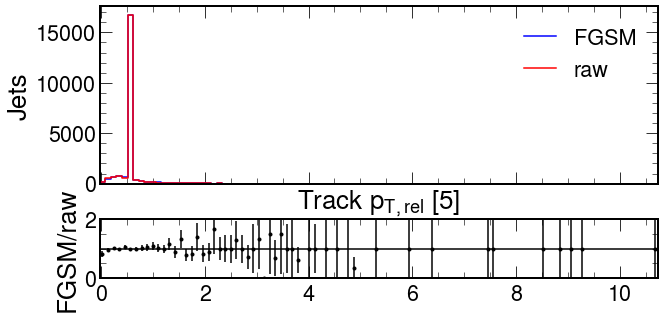

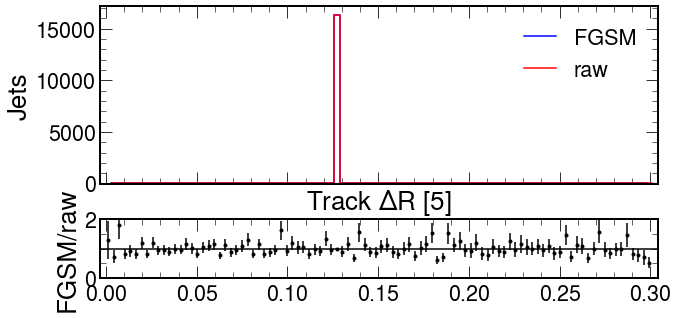

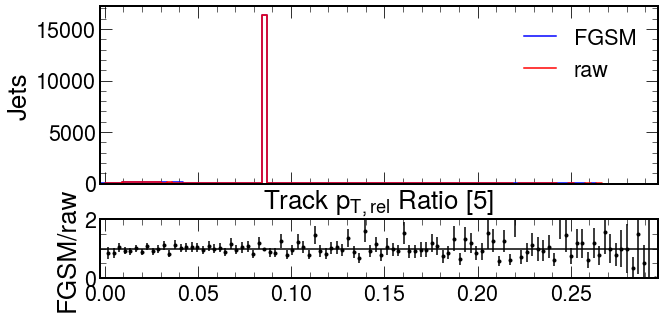

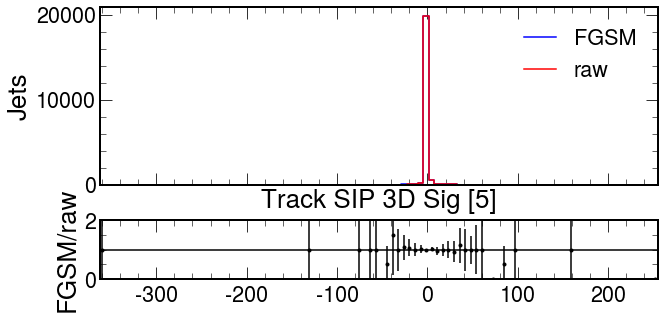

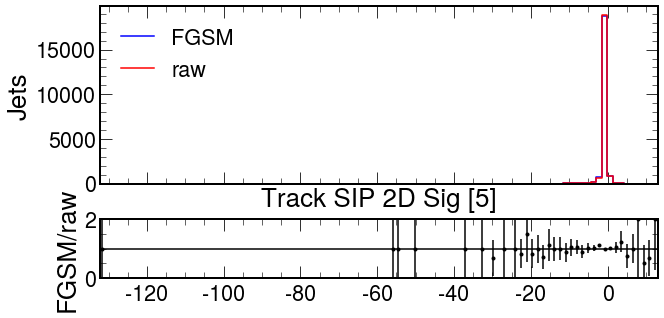

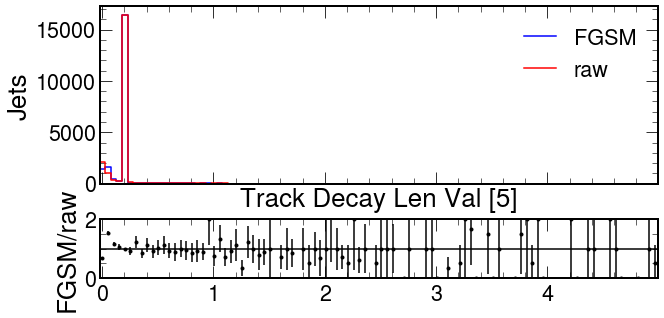

In [41]:
compare_inputs(47,epsilon,minimum=None,maximum=None)
compare_inputs(48,epsilon,minimum=None,maximum=None)
compare_inputs(49,epsilon,minimum=None,maximum=None)
compare_inputs(50,epsilon,minimum=None,maximum=None)
compare_inputs(51,epsilon,minimum=None,maximum=None)
compare_inputs(52,epsilon,minimum=None,maximum=None)
compare_inputs(53,epsilon,minimum=None,maximum=None)

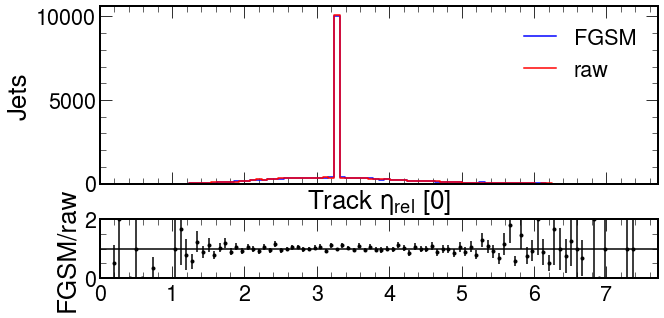

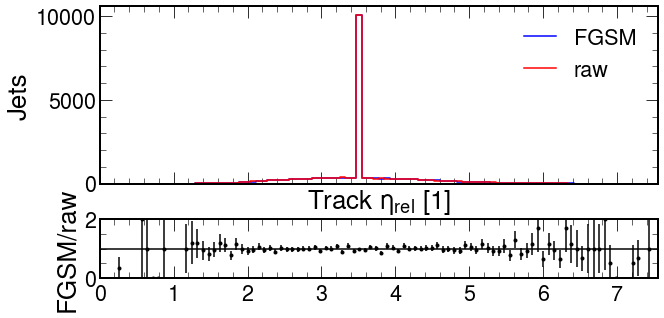

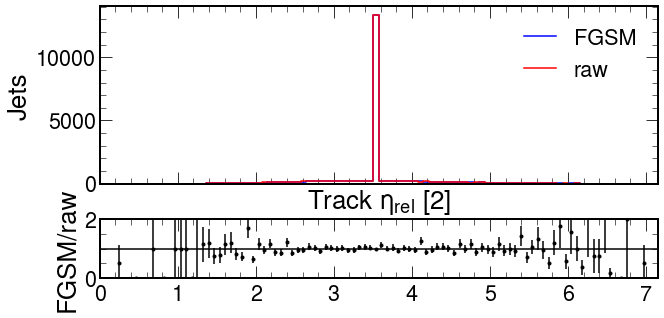

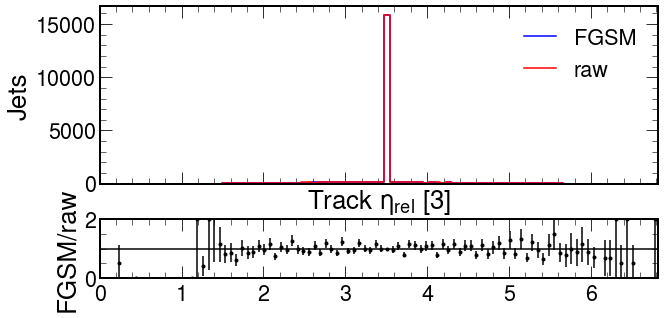

In [42]:
compare_inputs(54,epsilon,minimum=0,maximum=None)
compare_inputs(55,epsilon,minimum=0,maximum=None)
compare_inputs(56,epsilon,minimum=0,maximum=None)
compare_inputs(57,epsilon,minimum=0,maximum=None)

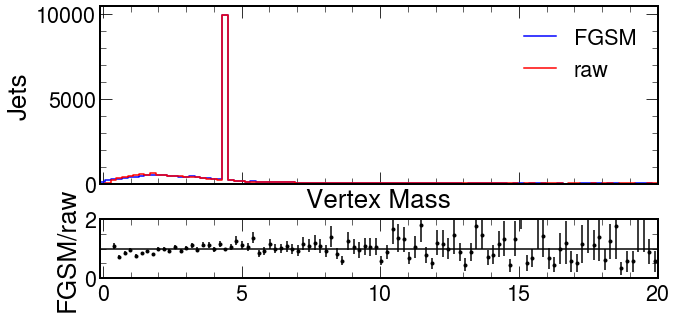

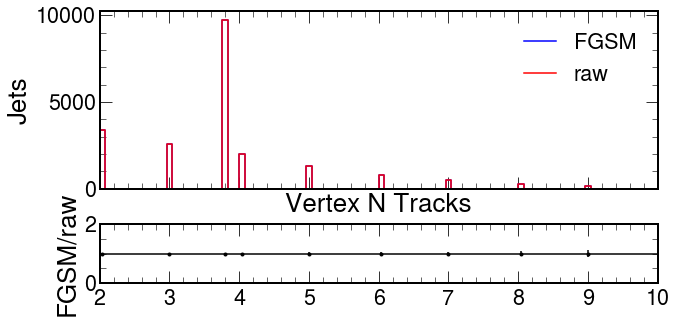

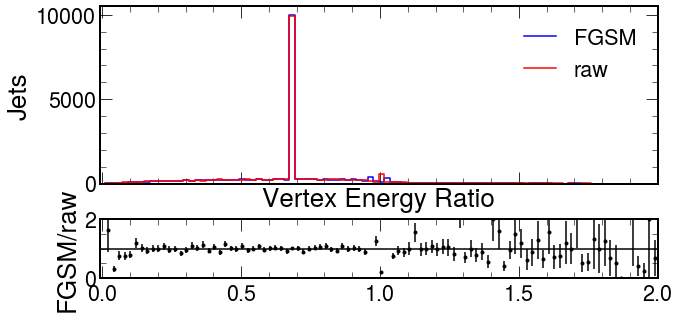

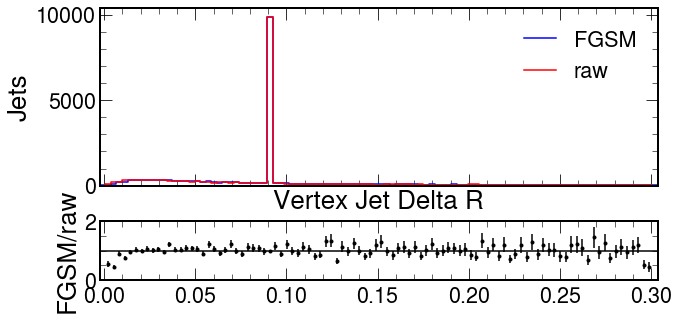

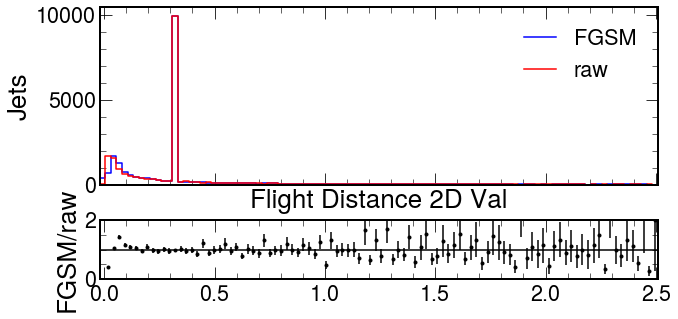

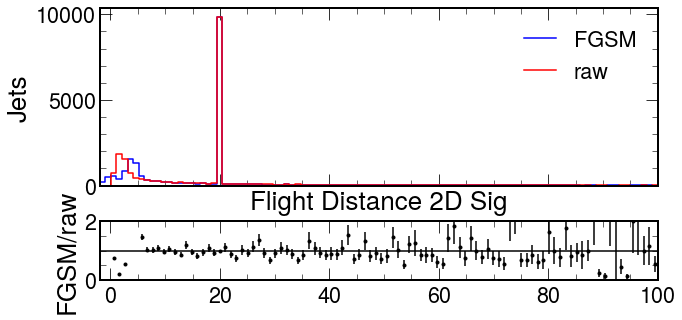

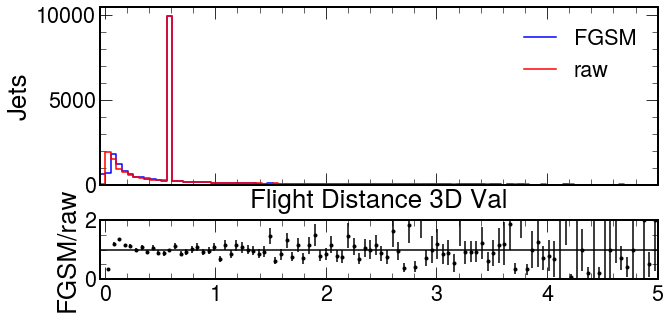

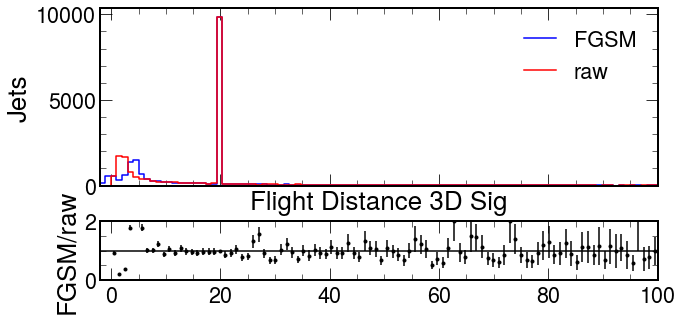

In [43]:
compare_inputs(58,epsilon,minimum=None,maximum=20)
compare_inputs(59,epsilon,minimum=None,maximum=10)
compare_inputs(60,epsilon,minimum=None,maximum=2)
compare_inputs(61,epsilon,minimum=None,maximum=None)
compare_inputs(62,epsilon,minimum=None,maximum=None)
compare_inputs(63,epsilon,minimum=None,maximum=100)
compare_inputs(64,epsilon,minimum=None,maximum=5)
compare_inputs(65,epsilon,minimum=None,maximum=100)